In [3]:
import pandas as pd
df=pd.read_csv('mydataa.csv')
df.head()

,SOC,B_Vol,B_Curr
0,79.0,52.696997,-5269.705003
1,79.0,52.696997,-3940.728070
2,79.0,52.696997,-2874.839232
3,79.0,52.696997,-2097.267720
4,79.0,52.696997,-1530.029647


In [5]:
df.tail()

,SOC,B_Vol,B_Curr
100091,79.012218,406.511279,0.0
100092,79.012218,406.511577,0.0
100093,79.012218,406.511855,0.0
100094,79.012218,406.512107,0.0
100095,79.012218,406.512326,0.0


In [7]:
df.describe()

,SOC,B_Vol,B_Curr
count,100096.000000,100096.000000,100096.000000
mean,79.006024,402.356014,123.649182
std,0.003595,4.288643,34.731027
min,78.999933,52.696997,-5269.705003
25%,79.002948,400.422812,125.002222
50%,79.006046,402.699131,125.056637
75%,79.009133,404.747949,126.288107
max,79.012218,406.512326,157.358802


In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features = df[['SOC', 'B_Vol', 'B_Curr']]
features_scaled = scaler.fit_transform(features)
scaled_df = pd.DataFrame(features_scaled, columns=['SOC', 'B_Vol', 'B_Curr'])

In [11]:
scaled_df['Power'] = scaled_df['B_Vol'] * scaled_df['B_Curr']
Q1 = scaled_df['Power'].quantile(0.25)
Q3 = scaled_df['Power'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = scaled_df[(scaled_df['Power'] >= lower_bound) & (scaled_df['Power'] <= upper_bound)]
data.to_csv('mydatab.csv', index=False)

In [13]:
df2=pd.read_csv('mydatab.csv')
time_step = 0.2 / len(df2)
df2['SOC_Change_Rate'] = df2['SOC'].diff() / time_step

In [15]:
df2.describe()

,SOC,B_Vol,B_Curr,Power,SOC_Change_Rate
count,97212.000000,97212.000000,97212.000000,97212.000000,97211.000000
mean,0.510490,0.989388,0.994487,0.983930,4.975603
std,0.284132,0.006445,0.001317,0.005866,0.332306
min,0.004890,0.971092,0.971005,0.961554,0.000000
25%,0.267442,0.983345,0.994039,0.978373,4.747742
50%,0.512108,0.989576,0.994049,0.983665,4.747743
75%,0.756086,0.995168,0.994298,0.989213,5.143387
max,1.000000,1.000000,1.000000,0.994026,6.330324


In [17]:
df2['Voltage_StdDev'] = df2['B_Vol'].rolling(window=5, min_periods=1).std()
df2['Current_StdDev'] = df2['B_Curr'].rolling(window=5, min_periods=1).std()

In [19]:
df2.to_csv('mydatac.csv', index=False)

In [21]:
df3=pd.read_csv('mydatac.csv')
df3.describe()

,SOC,B_Vol,B_Curr,Power,SOC_Change_Rate,Voltage_StdDev,Current_StdDev
count,97212.000000,97212.000000,97212.000000,97212.000000,97211.000000,9.721100e+04,9.721100e+04
mean,0.510490,0.989388,0.994487,0.983930,4.975603,7.507841e-07,1.177588e-06
std,0.284132,0.006445,0.001317,0.005866,0.332306,1.696139e-06,7.387848e-05
min,0.004890,0.971092,0.971005,0.961554,0.000000,0.000000e+00,0.000000e+00
25%,0.267442,0.983345,0.994039,0.978373,4.747742,2.346458e-07,2.394235e-07
50%,0.512108,0.989576,0.994049,0.983665,4.747743,4.985089e-07,4.558363e-07
75%,0.756086,0.995168,0.994298,0.989213,5.143387,8.322482e-07,6.942901e-07
max,1.000000,1.000000,1.000000,0.994026,6.330324,2.185752e-05,1.261420e-02


In [23]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [25]:
# Assuming 'Power' is the target variable (energy consumption)
X = df3[['SOC', 'B_Vol', 'B_Curr', 'SOC_Change_Rate', 'Voltage_StdDev', 'Current_StdDev']]  # Features
y = df3['Power']  # Target

In [27]:
X = X.dropna()
y = y[X.index]

In [29]:
X = X.iloc[:len(y)]

In [31]:
print(X.shape, y.shape)

(97211, 6) (97211,)


In [33]:
X = X.apply(pd.to_numeric, errors='coerce')

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [41]:
selector = SelectFromModel(model, threshold="mean", importance_getter="auto")
X_selected = selector.transform(X_train)

E:\anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [43]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 3.572063561047924e-05
Mean Squared Error: 2.535833556689449e-09
R^2 Score: 0.9999251197610652


In [45]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f'Cross-Validation R² Scores: {cv_scores}')
print(f'Mean R² Score: {np.mean(cv_scores)}')

Cross-Validation R² Scores: [0.9999233  0.99992838 0.9995982  0.99992959 0.9999287 ]
Mean R² Score: 0.9998616342190296


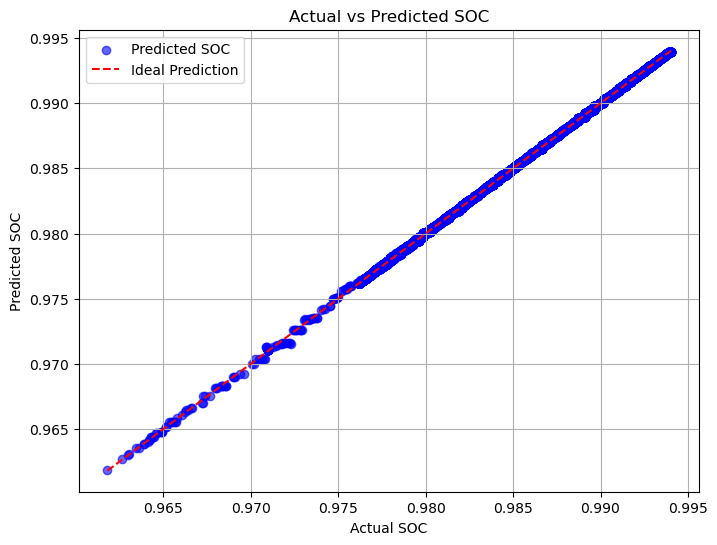

In [50]:
import matplotlib.pyplot as plt

# Assuming `y_test` is the actual SOC values and `y_pred` is the predicted SOC values from the Gradient Boost model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted SOC', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Prediction')
plt.title('Actual vs Predicted SOC')
plt.xlabel('Actual SOC')
plt.ylabel('Predicted SOC')
plt.legend()
plt.grid(True)
plt.savefig("soc_gradboost.png", format="png", dpi=300)
plt.show()

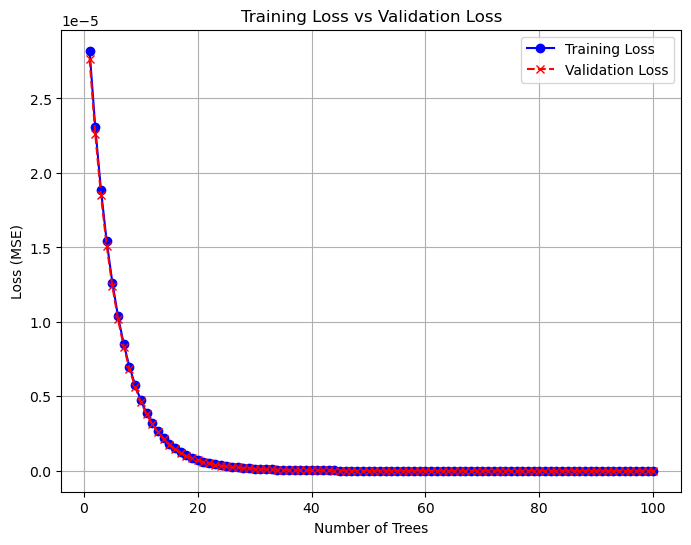

In [64]:
import numpy as np
training_loss = []
validation_loss = []

# Train the model iteratively and capture loss
for y_train_pred, y_val_pred in zip(model.staged_predict(X_train), model.staged_predict(X_test)):
    train_loss = mean_squared_error(y_train, y_train_pred)
    val_loss = mean_squared_error(y_test, y_val_pred)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)

# Plot Training vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss', color='blue', linestyle='-', marker='o')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss', color='red', linestyle='--', marker='x')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Number of Trees')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig("valloss_gradboost.png", format="png", dpi=300)
plt.show()